Laplace Demo
------------

This demo introduces basic usage of dune-fempy, using the poisson equation as an example. Namely,

\begin{gather}
- \Delta u + u = f \quad \text{in } \Omega \\
\nabla u \cdot \textbf{n} = 0 \quad \text{on } \Gamma
\end{gather}


If you have compiled DUNE against MPI, we strongly advise you to first initialize MPI from Python.
At least OpenMPI is known to fail, if initialized only in the dune-fempy library.

In [1]:
import dune.fem
dune.fem.parameter.append("../data/parameter")

2016-10-13 20:25:42,238  INFO  MPI initialized successfully
2016-10-13 20:25:42,276  INFO  Started building dune-py module
2016-10-13 20:25:42,277  INFO  Using existing dune-py module in /home/martin/python/dune-debug/.cache/dune-py
2016-10-13 20:25:43,764  INFO  Successfully built dune-py module


First, we create our computational grid. Our domain will be the unit square divided into 16x16 quadrilaterals. To actually create the grid, we choose an implementation of the DUNE grid interface: a 2-dimensional ALUGrid with simplices and conforming bisection refinement.

In [2]:
import dune.create as create
grid = create.grid("ALUConform", dune.grid.cartesianDomain([0, 0], [1, 1], [8, 8]), dimgrid=2)

2016-10-13 20:25:43,815  INFO  Importing create registries from [ dune.alugrid dune.fem dune.grid dune.spgrid ]


We set up the base variables u, v and x in UFL.

In [3]:
from dune.ufl import Space
from ufl import TestFunction, TrialFunction, SpatialCoordinate
uflSpace = Space((grid.dimGrid, grid.dimWorld), 1)
u = TrialFunction(uflSpace)
v = TestFunction(uflSpace)
x = SpatialCoordinate(uflSpace.cell())

Next we define the equation for the weak form, given by

\begin{equation}
\int_{\Omega} uv + \nabla u\cdot\nabla v \ dx =  \int_{\Omega} f v \ dx.
\end{equation}

Here, we also take $f = \cos(2\pi x_0)\cos(2\pi x_1)$

In [4]:
from math import pi
from ufl import cos, as_vector, dx, grad, inner
f = cos(2*pi*x[0])*cos(2*pi*x[1])
exact = as_vector( [cos(2.*pi*x[0])*cos(2.*pi*x[1])] )
equation = (inner(grad(u), grad(v)) + inner(u,v)) * dx == f * v[0] * dx
equation

\begin{equation*}\int_\Omega\varphi^{0}\cdot\varphi^{1} + \nabla \varphi^{0}\cdot\nabla \varphi^{1}\,dx=\int_\Omega\varphi^{0}_{0}\,\cos\left(6.283185307179586\,x_{0}\right)\,\cos\left(6.283185307179586\,x_{1}\right)\,dx\end{equation*}

We create the space and the model.

In [5]:
spc = create.space("Lagrange", grid, dimrange=1, order=1)
model = create.model("elliptic", grid, equation, exact=exact, dirichlet={ 1:exact })

We create the scheme and set parameters for the solver.

In [6]:
scheme = create.scheme("h1", spc, model, "scheme",\
       parameters=\
       {"fem.solver.newton.linabstol": 1e-10,
        "fem.solver.newton.linreduction": 1e-10,
        "fem.solver.newton.verbose": 0,
        "fem.solver.newton.linear.verbose": 0},\
        storage="istl")

We create a grid function for our exact solution.

In [7]:
exact_gf = create.function("ufl", grid, "exact", 5, exact)

2016-10-13 20:25:45,197  INFO  Started compiling localFunction
2016-10-13 20:25:57,941  INFO  Successfully compiled localFunction


We set up a function for plotting the data using matplotlib.

In [8]:
try:
    from matplotlib import pyplot
    from numpy import amin, amax, linspace
    from IPython.core.display import display

    def plot(grid, solution):
        triangulation = grid.triangulation(4)
        data = solution.pointData(4)

        levels = linspace(amin(data[:,0]), amax(data[:,0]), 256)

        fig = pyplot.figure()
        fig.gca().set_aspect('equal')
        pyplot.triplot(grid.triangulation(), antialiased=True, linewidth=0.2, color='black')
        pyplot.tricontourf(triangulation, data[:,0], cmap=pyplot.cm.rainbow, levels=levels)
        display(fig)
except ImportError as e:
    print(e)
    def plot(grid, solution):
        pass

Now we solve the system. We assign the solution to `uh`, and define a function to calculate the $L^2$ error, i.e. $|u_h - u|_{L^2}$. We output the data to a vtk file with name `laplace`, and plot it using `plot`. Finally we refine the grid twice and repeat the process. 

solve on level 0 number of dofs= 81
size: 128 L2-error: 0.07892296565023203


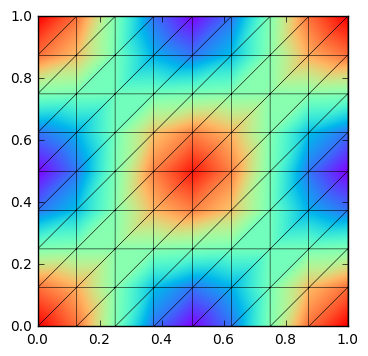

solve on level 1 number of dofs= 289
size: 512 L2-error: 0.016940197023399852


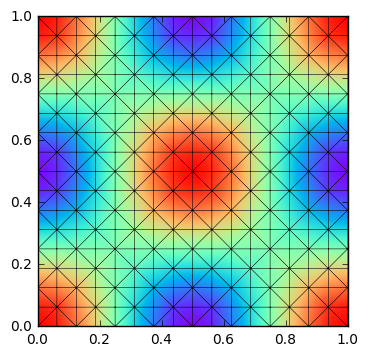

In [9]:
from math import sqrt
for i in range(2):
    print("solve on level", i, "number of dofs=", grid.size(2))
    uh = scheme.solve()
    def l2error(en,x):
        val = uh.localFunction(en).evaluate(x) - exact_gf.localFunction(en).evaluate(x)
        return [ val[0]*val[0] ];
    l2error_gf = create.function("local", grid, "error", 5, l2error)
    error = sqrt(l2error_gf.integrate()[0])

    print("size:", grid.size(0), "L2-error:", error)
    grid.writeVTK("laplace", pointdata=[uh, l2error_gf])

    plot(grid, uh)

    grid.hierarchicalGrid.globalRefine(2)

Congratulations! You have successfully solved and visualized your first PDE using dune-fempy.